In [6]:
import matplotlib.pyplot as plt
from itertools import cycle
from matplotlib.pyplot import cm

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy import integrate
from csaps import csaps

from pathlib import Path

import functions as f
from lmfit import Model

In [2]:
INPUT_DIR = Path('./../gamma=2.0/')

In [3]:
snapshots = [0, 10, 20, 200, 400]
#snapshots = [0, 100]

In [4]:
r_e = np.geomspace(7e-2, 50, 101)

dmdr_3D = pd.DataFrame(data={'r':r_e})
dmdr_2D = pd.DataFrame(data={'r':r_e})

popts_3D = pd.DataFrame()
popts_2D = pd.DataFrame()

### in 3D

In [7]:
for snap in snapshots:
    dmdr = 0
    
    for random in [11, 12, 13, 21, 22, 23, 31, 32, 33]:
        folder = Path(f'{INPUT_DIR}/run-2.0-0.20-{random}')
        dmdr += f.get_dmdr(folder, snap, r_e, 3)
        
    dmdr = dmdr / 9

    
    fmodel = Model(f.dmdr_profile)
    
    fmodel.set_param_hint('ro0', value=500, min=10, max=20000.0)
    fmodel.set_param_hint('a', value=0.5, min=0.1, max=20.0)
    fmodel.set_param_hint('gamma', value=0.3, min=1e-9, max=2.0)
    params = fmodel.make_params()
    
    params['dim'].vary = False
    params['dim'].value = 3
    
    result = fmodel.fit(data=dmdr, params=params, r=r_e)
    
    
    dmdr_3D[snap] = dmdr
    popts_3D[snap] = [result.params['ro0'].value, result.params['a'].value, result.params['gamma'].value]

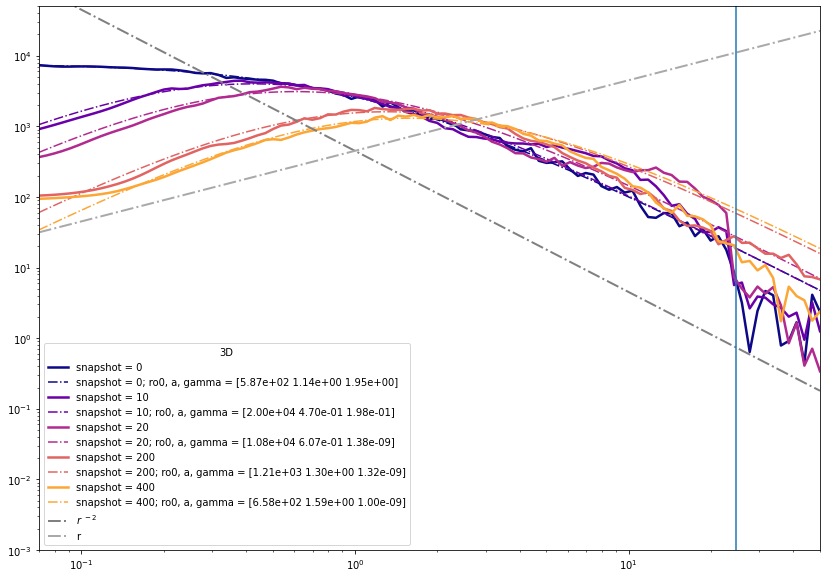

In [8]:
cycol = iter(cm.plasma(np.linspace(0, 1, len(snapshots)+1)))
np.set_printoptions(formatter={'float': "{0:0.2e}".format})

fig, ax = plt.subplots(figsize=(14, 10))
for snap in dmdr_3D.columns[1:]:
    c=next(cycol)
    ax.plot(dmdr_3D['r'], dmdr_3D[snap], label=f'snapshot = {snap}', 
            c=c, lw=2.5)
    ax.plot(dmdr_3D['r'], f.dmdr_profile(dmdr_3D['r'], *popts_3D[snap], 3), 
            c=c, ls='-.', label=f'snapshot = {snap}; ro0, a, gamma = {popts_3D[snap].values}')
    
ax.plot(dmdr_3D['r'], 450 / dmdr_3D['r'] ** 2, c='gray', label=r'$r^{\ -2}$', ls= '-.', lw=2)
ax.plot(dmdr_3D['r'], 450 * dmdr_3D['r'] , c='darkgrey', label='r', ls= '-.', lw=2)
ax.plot([1.23 * 20, 1.23 * 20], [1e-3, 1e5])   
    
ax.set_ylim(1e-3, 5e4)
ax.set_xlim(r_e.min(), r_e.max())
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(title='3D')

### in 2D

In [9]:
for snap in snapshots:
    dmdr = 0
    
    for random in [11, 12, 13, 21, 22, 23, 31, 32, 33]:
        folder = Path(f'{INPUT_DIR}/run-2.0-0.20-{random}')
        dmdr += f.get_dmdr(folder, snap, r_e, 2)
    dmdr = dmdr / 9
#     popt_dehnen_counts, pcov_dehnen_counts = curve_fit(f.dmdr_profile_2D, r_e, dmdr, 
#                                                        bounds=bounds.T, p0=init_vals, maxfev=7000)

    fmodel = Model(f.dmdr_profile)
    
    fmodel.set_param_hint('ro0', value=500, min=10, max=20000.0)
    fmodel.set_param_hint('a', value=0.5, min=0.1, max=20.0)
    fmodel.set_param_hint('gamma', value=0.3, min=1e-9, max=2.0)
    params = fmodel.make_params()
    
    params['dim'].vary = False
    params['dim'].value = 2
    
    result = fmodel.fit(data=dmdr, params=params, r=r_e)
    
    dmdr_2D[snap] = dmdr
    popts_2D[snap] = [result.params['ro0'].value, result.params['a'].value, result.params['gamma'].value]

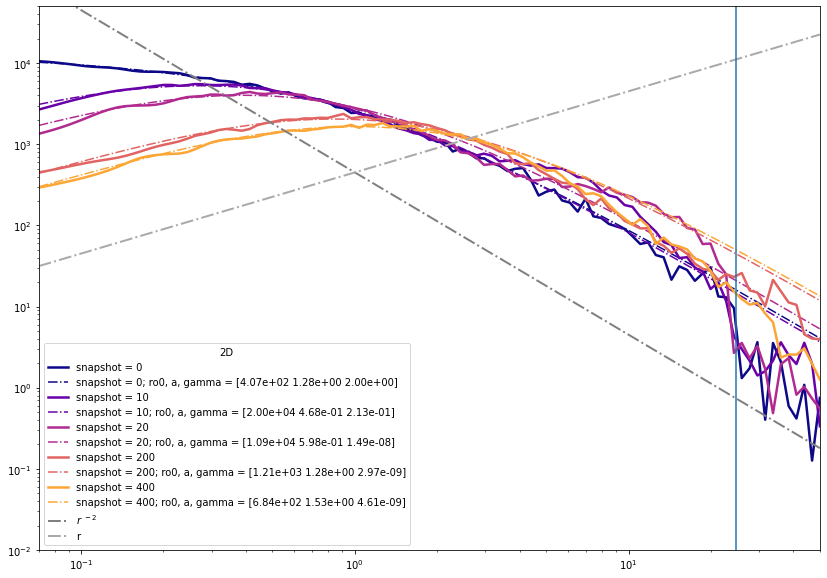

In [10]:
cycol = iter(cm.plasma(np.linspace(0, 1, len(snapshots)+1)))
np.set_printoptions(formatter={'float': "{0:0.2e}".format})

fig, ax = plt.subplots(figsize=(14, 10))
for snap in dmdr_2D.columns[1:]:
    c=next(cycol)
    ax.plot(dmdr_2D['r'], dmdr_2D[snap], label=f'snapshot = {snap}', 
            c=c, lw=2.5)
#     ax.plot(dmdr_2D['r'], f.dmdr_profile_2D(dmdr_2D['r'], *popts_2D_log[snap]),
#             c=c, ls='--', label=f'snapshot = {snap}; ro0, a, gamma = {popts_2D_log[snap].values}; log')
    ax.plot(dmdr_2D['r'], f.dmdr_profile(dmdr_2D['r'], *popts_2D[snap], 2), 
            c=c, ls='-.', label=f'snapshot = {snap}; ro0, a, gamma = {popts_2D[snap].values}')
    
    
ax.plot(dmdr_3D['r'], 450 / dmdr_3D['r'] ** 2, c='gray', label=r'$r^{\ -2}$', ls= '-.', lw=2)
ax.plot(dmdr_3D['r'], 450 * dmdr_3D['r'] , c='darkgrey', label='r', ls= '-.', lw=2)
ax.plot([1.23 * 20, 1.23*20], [1e-3, 1e5])   
    
ax.set_ylim(1e-2,5e4)
ax.set_xlim(r_e.min(), r_e.max())

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(title='2D')